In [40]:

import os
import numpy as np
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, WeightedRandomSampler, DataLoader

from pathlib import Path
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

In [41]:
data_dir = "E:/ML_Pharamachain\data\dataset"

Fake_dir = os.path.join(data_dir, 'Fake')
Real_dir = os.path.join(data_dir, 'Real')

fake_count = len([ f for f in os.listdir(Fake_dir) ])
real_count = len([ f for f in os.listdir(Real_dir) ])

print(f"Fake images: {fake_count}")
print(f"Real images: {real_count}")

Fake images: 240
Real images: 422


In [42]:
class CustomDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.classes = ["Fake", "Real"]
        self.images = []
        self.labels = []

        # Define common image extensions to filter out non-image files
        image_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff')

        # Only Fake and Real folders
        for label, folder_name in enumerate(["Fake", "Real"]):
            folder_path = Path(root_dir) / folder_name
            
            # Filter for files with image extensions
            for img_path in folder_path.glob("*"):
                if img_path.is_file() and img_path.suffix.lower() in image_extensions:
                    self.images.append(img_path)
                    self.labels.append(label)


    def __len__(self):
        return len(self.images)


    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert("RGB")

        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]
        return img, label


dataset = CustomDataset(data_dir)                                 # initialy we are not transforming dataset

print(f"Total Classes: {dataset.classes}")
print(f"Total images: {len(dataset)}")

Total Classes: ['Fake', 'Real']
Total images: 661


In [43]:
dataset_size = len(dataset)

train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])       # tells PyTorch how many samples should go into each split.


In [44]:
print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 462
Val size: 99
Test size: 100


In [45]:

train_transform = transforms.Compose([
    
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    
])

val_test_transform = transforms.Compose([
    
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    
])


In [46]:
class TransformSubset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    
    def __getitem__(self, idx):
        img, label = self.subset[idx]      
        img = self.transform(img)             
        return img, label
    
    def __len__(self):
        return len(self.subset)


In [47]:
train_dataset = TransformSubset(train_dataset, train_transform)
val_dataset   = TransformSubset(val_dataset, val_test_transform)
test_dataset  = TransformSubset(test_dataset, val_test_transform)


In [48]:
def count_classes(split_dataset):

    labels = [split_dataset[i][1] for i in range(len(split_dataset))]              # img, label = dataset[i] here i=0 image i=1 lable
    fake_count = labels.count(0)
    real_count = labels.count(1)

    return fake_count, real_count

train_fake, train_real = count_classes(train_dataset)                      # here train_dataset is a Subset object, not your original dataset.
val_fake, val_real = count_classes(val_dataset)
test_fake, test_real = count_classes(test_dataset)

print("Train  → Fake:", train_fake, " Real:", train_real)
print("Val    → Fake:", val_fake, " Real:", val_real)
print("Test   → Fake:", test_fake, " Real:", test_real)


Train  → Fake: 171  Real: 291
Val    → Fake: 29  Real: 70
Test   → Fake: 40  Real: 60


In [49]:

def Sampler(train_subset):

  labels = [train_subset[i][1] for i in range(len(train_subset))]            # here labels is a NumPy array of integers (class labels). img, label = dataset[i] here i=0 image i=1 lable

  class_sample_counts = np.bincount(labels)                                 # most useful funtion to count class frequncies i.e class_sample_counts = [240, 421] F, R

  class_weights = 1.0 / class_sample_counts                                 # [0.00609756 0.0033557 ] class 0 gets high weights

  sample_weights = class_weights[labels]                                    # calss_weights assign each sample the weight of its class using NumPy’s fancy indexing. [0.00609756 0.0033557  0.00609756 ...

  sampler = WeightedRandomSampler(
      weights=sample_weights,
      num_samples=len(sample_weights),
      replacement=True
  )

  return sampler

train_sampler = Sampler(train_dataset)


In [50]:

# Change num_workers=2 to num_workers=0
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    sampler=train_sampler,
    num_workers=0,      # Fixed: Use 0 for local/Windows environments
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    num_workers=0,      # Fixed
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=0,      # Fixed
    pin_memory=True
)

# to combine them into one Dataloader dictionary

dataloaders = {
    "train_loader": train_loader,
    "val_loader": val_loader,
    "test_loader": test_loader
}

In [51]:
balanced_labels = []

for i in range(500):  # sample 500 items
    _, label = train_dataset[train_sampler.weights.multinomial(1).item()]
    balanced_labels.append(label)

print("Fake:", balanced_labels.count(0))
print("Real:", balanced_labels.count(1))



Fake: 260
Real: 240


In [52]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [53]:
def load_pretrained_resnet50(num_classes=2):

    model =  models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

    # Replace the final fully connected layer for binary classification
    num_features = model.fc.in_features

    model.fc = nn.Sequential(

        nn.Linear(num_features, 1024),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 2))

    return model

In [54]:
def set_resnet_trainable_layers(model, unfreeze_from_layer=None):
    for param in model.parameters():
        param.requires_grad = False

    if unfreeze_from_layer is not None:
        # Unfreeze all layers starting from this layer
        for name, param in model.named_parameters():
            if unfreeze_from_layer in name or 'fc' in name:
                param.requires_grad = True
    else:
        # Only the classifier fc is trainable
        for param in model.fc.parameters():
            param.requires_grad = True

    # Summary
    trainable_layers = [name for name, p in model.named_parameters() if p.requires_grad]
    print(f"Trainable layers ({len(trainable_layers)}):")

    for name in trainable_layers:
        print(f"  {name}")


In [55]:
def setup_training(model, device, learning_rate=0.001):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # REMOVED: verbose=True
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3
    )

    return criterion, optimizer, scheduler

In [56]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc="Training")                  # Wraps the dataloader with a progress bar

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Stats
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pbar.set_postfix({'loss': running_loss / total, 'acc': 100 * correct / total})

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc


In [57]:
def validate(model, val_loader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_acc = 100 * correct / total

    return val_loss, val_acc


In [58]:
class CheckpointManager:
    """Manages saving best and periodic checkpoints"""

    def __init__(self, save_dir='./checkpoints', keep_top_k=3):
        self.save_dir = save_dir
        self.keep_top_k = keep_top_k
        self.best_metrics = []  # List of (val_acc, val_loss, epoch, filepath)

        import os
        os.makedirs(save_dir, exist_ok=True)

    def save_checkpoint(self, model, optimizer, epoch, train_loss, train_acc,
                       val_loss, val_acc, is_best=False):
        """Save model checkpoint with metadata"""

        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc,
        }

        filename = f'checkpoint_epoch_{epoch:03d}_acc_{val_acc:.2f}.pth'
        filepath = f'{self.save_dir}/{filename}'

        torch.save(checkpoint, filepath)

        if is_best:
            # Save as best model
            best_path = f'{self.save_dir}/best_model.pth'
            torch.save(checkpoint, best_path)
            print(f"✓ Best model saved! Val Acc: {val_acc:.2f}%")

        # Track this checkpoint
        self.best_metrics.append((val_acc, val_loss, epoch, filepath))
        self.best_metrics.sort(reverse=True)  # Sort by val_acc descending

        # Keep only top-k checkpoints
        if len(self.best_metrics) > self.keep_top_k:
            _, _, _, old_path = self.best_metrics.pop()
            import os
            if os.path.exists(old_path):
                os.remove(old_path)
                print(f"Removed old checkpoint: {old_path}")

        return filepath

    def load_best_model(self, model, optimizer=None):
        """Load the best saved model"""
        best_path = f'{self.save_dir}/best_model.pth'
        checkpoint = torch.load(best_path)
        model.load_state_dict(checkpoint['model_state_dict'])

        if optimizer:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        print(f"Loaded best model from epoch {checkpoint['epoch']} "
              f"with Val Acc: {checkpoint['val_acc']:.2f}%")
        
        return checkpoint

In [59]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                scheduler, device, num_epochs=20, patience=5, checkpoint_manager=None):
    """
    Train the model with early stopping and checkpoint management
    """
    if checkpoint_manager is None:
        checkpoint_manager = CheckpointManager()

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    best_val_acc = 0
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Save checkpoint (periodic + best)
        is_best = False
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = val_loss
            is_best = True
            patience_counter = 0
        else:
            patience_counter += 1

        checkpoint_manager.save_checkpoint(
            model, optimizer, epoch, train_loss, train_acc,
            val_loss, val_acc, is_best=is_best
        )

        # Learning rate scheduling
        scheduler.step(val_acc)

        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

    return train_losses, train_accs, val_losses, val_accs, checkpoint_manager

In [60]:
def evaluate_on_test(model, test_loader, device):
    """Evaluate on test set"""
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = 100 * correct / total
    print(f"\nTest Accuracy: {test_acc:.2f}%")

    return test_acc, all_predictions, all_labels


In [61]:
def plot_training_history(train_losses, train_accs, val_losses, val_accs):
    """Plot training and validation metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(train_accs, label='Train Acc')
    ax2.plot(val_accs, label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

Using device: cpu
Trainable layers (6):
  fc.0.weight
  fc.0.bias
  fc.3.weight
  fc.3.bias
  fc.6.weight
  fc.6.bias

Epoch 1/15


Training:   0%|                                                                                 | 0/15 [00:00<?, ?it/s]C:\Users\Admin\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)
Training: 100%|█████████████████████████████████████████████████| 15/15 [00:42<00:00,  2.86s/it, loss=0.0114, acc=85.5]


Train Loss: 0.3504, Train Acc: 85.50%
Val Loss: 0.1218, Val Acc: 93.94%
✓ Best model saved! Val Acc: 93.94%

Epoch 2/15


Training: 100%|████████████████████████████████████████████████| 15/15 [00:52<00:00,  3.51s/it, loss=0.00387, acc=96.3]


Train Loss: 0.1192, Train Acc: 96.32%
Val Loss: 0.0910, Val Acc: 96.97%
✓ Best model saved! Val Acc: 96.97%

Epoch 3/15


Training: 100%|████████████████████████████████████████████████| 15/15 [00:47<00:00,  3.18s/it, loss=0.00321, acc=96.1]


Train Loss: 0.0989, Train Acc: 96.10%
Val Loss: 0.1003, Val Acc: 94.95%

Epoch 4/15


Training: 100%|████████████████████████████████████████████████| 15/15 [00:47<00:00,  3.16s/it, loss=0.00132, acc=98.1]


Train Loss: 0.0407, Train Acc: 98.05%
Val Loss: 0.0804, Val Acc: 95.96%
Removed old checkpoint: ./medicine_checkpoints/checkpoint_epoch_000_acc_93.94.pth

Epoch 5/15


Training: 100%|████████████████████████████████████████████████| 15/15 [00:47<00:00,  3.19s/it, loss=0.00108, acc=98.5]


Train Loss: 0.0332, Train Acc: 98.48%
Val Loss: 0.0757, Val Acc: 95.96%
Removed old checkpoint: ./medicine_checkpoints/checkpoint_epoch_002_acc_94.95.pth

Epoch 6/15


Training: 100%|███████████████████████████████████████████████| 15/15 [00:51<00:00,  3.46s/it, loss=0.000852, acc=98.7]


Train Loss: 0.0263, Train Acc: 98.70%
Val Loss: 0.0698, Val Acc: 96.97%
Removed old checkpoint: ./medicine_checkpoints/checkpoint_epoch_004_acc_95.96.pth

Epoch 7/15


Training: 100%|███████████████████████████████████████████████| 15/15 [00:47<00:00,  3.20s/it, loss=0.000913, acc=98.9]


Train Loss: 0.0281, Train Acc: 98.92%
Val Loss: 0.0900, Val Acc: 96.97%
Removed old checkpoint: ./medicine_checkpoints/checkpoint_epoch_003_acc_95.96.pth

Early stopping triggered after 7 epochs
Loaded best model from epoch 1 with Val Acc: 96.97%

Test Accuracy: 96.00%


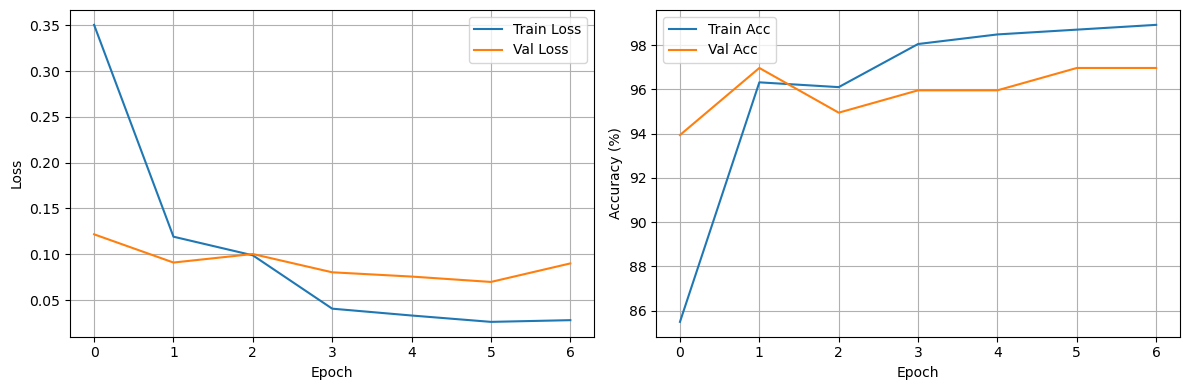


Training Completed!
Best Model - Epoch: 1, Val Acc: 96.97%
Test Accuracy: 96.00%
Saved Checkpoints in: ./medicine_checkpoints/


In [62]:
# Device setup

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. Load model
model = load_pretrained_resnet50(num_classes=2)

# 2. Optional: Freeze early layers 
set_resnet_trainable_layers(model, unfreeze_from_layer=None)

# 3. Setup training
criterion, optimizer, scheduler = setup_training(model, device, learning_rate=0.001)

# 5. Setup checkpoint manager
checkpoint_manager = CheckpointManager(save_dir='./medicine_checkpoints', keep_top_k=3)

# 6. Train model
train_losses, train_accs, val_losses, val_accs, checkpoint_manager = train_model(
    model, train_loader, val_loader, criterion, optimizer,
    scheduler, device, num_epochs=15, patience=5, checkpoint_manager=checkpoint_manager
)

# 7. Load best model and evaluate on test set
best_checkpoint = checkpoint_manager.load_best_model(model, optimizer)
test_acc, predictions, labels = evaluate_on_test(model, test_loader, device)

# 8. Plot results
plot_training_history(train_losses, train_accs, val_losses, val_accs)

# Print checkpoint info
print("\n" + "="*50)
print("Training Completed!")
print("="*50)
print(f"Best Model - Epoch: {best_checkpoint['epoch']}, Val Acc: {best_checkpoint['val_acc']:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Saved Checkpoints in: ./medicine_checkpoints/")

Accuracy: 0.9600
Precision: 0.9375
Recall: 1.0000
F1-Score: 0.9677

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      0.90      0.95        40
        Real       0.94      1.00      0.97        60

    accuracy                           0.96       100
   macro avg       0.97      0.95      0.96       100
weighted avg       0.96      0.96      0.96       100



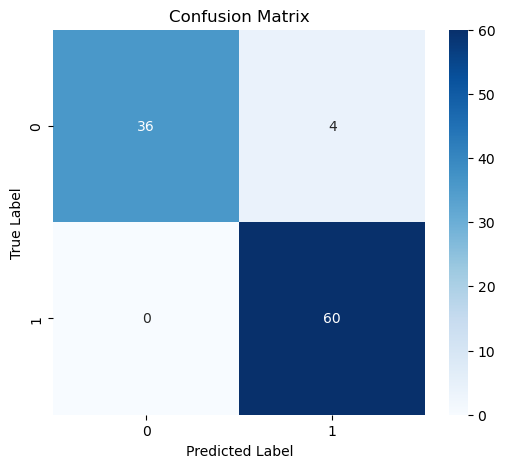

In [63]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# After getting predictions and labels from test set
accuracy = accuracy_score(labels, predictions)
precision = precision_score(labels, predictions)
recall = recall_score(labels, predictions)
f1 = f1_score(labels, predictions)
cm = confusion_matrix(labels, predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(labels, predictions, target_names=["Fake", "Real"]))

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()